## Enhancing Road Safety: Data-Driven Insights and Predictive Modeling for Car Accident Prevention

### Authors:
#### Anbu Suriya Kumar, DePaul University, School of Computing



### Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import folium
from folium.plugins import MarkerCluster
import requests
from datetime import datetime

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif, chi2

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler


### Data Exploration

In [ ]:
df = pd.read_csv("US_Accidents_March23_sampled_500k.csv")
df.shape

(500000, 46)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     500000 non-null  object 
 1   Source                 500000 non-null  object 
 2   Severity               500000 non-null  int64  
 3   Start_Time             500000 non-null  object 
 4   End_Time               500000 non-null  object 
 5   Start_Lat              500000 non-null  float64
 6   Start_Lng              500000 non-null  float64
 7   End_Lat                279623 non-null  float64
 8   End_Lng                279623 non-null  float64
 9   Distance(mi)           500000 non-null  float64
 10  Description            499999 non-null  object 
 11  Street                 499309 non-null  object 
 12  City                   499981 non-null  object 
 13  County                 500000 non-null  object 
 14  State                  500000 non-nu

In [ ]:
nullSum = df.isnull().sum().sum()
print(f'Null Count in Dataset: {nullSum}')

Null Count in Dataset: 829873


In [ ]:
df_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {df_duplicates}")

Number of duplicate rows: 0


In [ ]:
# Calcuating missing percentage

all_data_na = (df.isnull().sum() / len(df)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
End_Lat,44.0754
End_Lng,44.0754
Precipitation(in),28.5232
Wind_Chill(F),25.8034
Wind_Speed(mph),7.3974
Visibility(mi),2.2582
Wind_Direction,2.2394
Humidity(%),2.2260
Weather_Condition,2.2202
Temperature(F),2.0932


Text(0.5, 1.0, 'Percent of Missing Data by Feature')

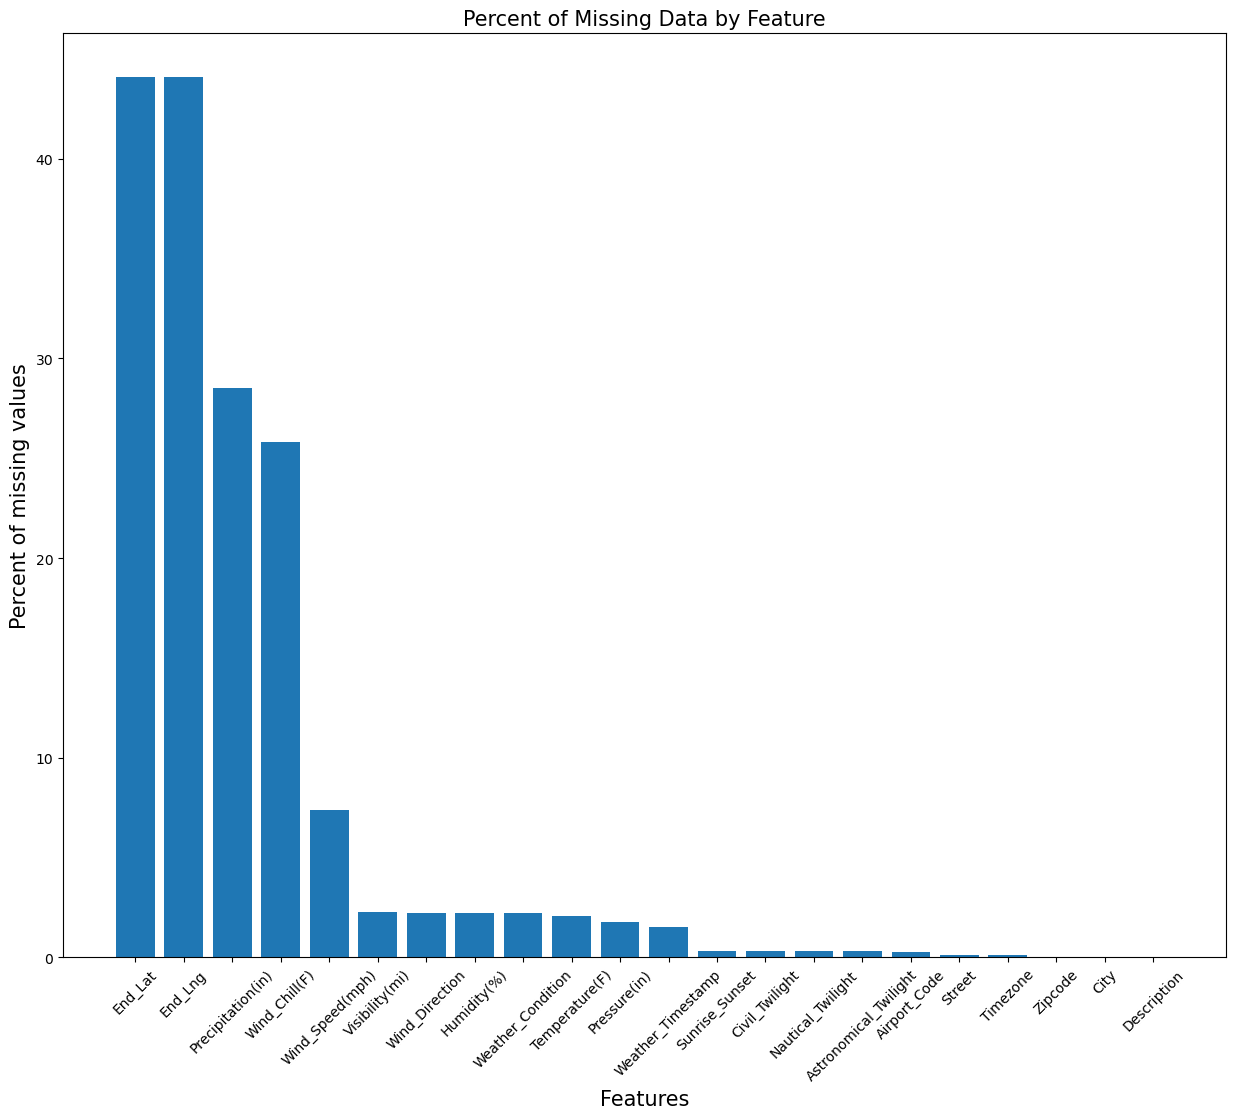

In [ ]:
plt.figure(figsize=(15, 12))
plt.bar(all_data_na.index, all_data_na)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Set labels and title
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent of Missing Data by Feature', fontsize=15)

In [ ]:
df = df.drop(['ID', 'Source'], axis=1)
df.info()

##### Instead try imputing values by avg for the above columns by weather type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 44 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Severity               500000 non-null  int64  
 1   Start_Time             500000 non-null  object 
 2   End_Time               500000 non-null  object 
 3   Start_Lat              500000 non-null  float64
 4   Start_Lng              500000 non-null  float64
 5   End_Lat                279623 non-null  float64
 6   End_Lng                279623 non-null  float64
 7   Distance(mi)           500000 non-null  float64
 8   Description            499999 non-null  object 
 9   Street                 499309 non-null  object 
 10  City                   499981 non-null  object 
 11  County                 500000 non-null  object 
 12  State                  500000 non-null  object 
 13  Zipcode                499884 non-null  object 
 14  Country                500000 non-nu

In [ ]:
df.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,500000.000000,500000.000000,500000.000000,279623.000000,279623.000000,500000.000000,489534.000000,370983.000000,488870.000000,491072.000000,488709.000000,463013.000000,357384.000000
mean,2.212748,36.206421,-94.736583,36.273192,-95.776553,0.564317,61.646254,58.229028,64.834921,29.536621,9.091540,7.681347,0.008289
std,0.486661,5.071411,17.405761,5.265333,18.120211,1.774872,19.000133,22.352246,22.826158,1.008666,2.708083,5.431361,0.101865
min,1.000000,24.562117,-124.497420,24.570110,-124.497419,0.000000,-77.800000,-53.200000,1.000000,0.120000,0.000000,0.000000,0.000000
25%,2.000000,33.416823,-117.233047,33.474773,-117.778324,0.000000,49.000000,43.000000,48.000000,29.370000,10.000000,4.600000,0.000000
50%,2.000000,35.832147,-87.794365,36.192669,-88.039013,0.029000,64.000000,62.000000,67.000000,29.860000,10.000000,7.000000,0.000000
75%,2.000000,40.082443,-80.359601,40.181341,-80.252449,0.465000,76.000000,75.000000,84.000000,30.030000,10.000000,10.400000,0.000000
max,4.000000,48.999569,-67.484130,48.998901,-67.484130,193.479996,207.000000,207.000000,100.000000,38.440000,130.000000,822.800000,10.130000


In [ ]:
# Printing Columns are categorical.
object_columns = df.select_dtypes(include=['object']).columns
print(f'The Following Columns Have Dtype as Object \n \n : {object_columns}')
object_columns.value_counts().sum()

The Following Columns Have Dtype as Object 
 
 : Index(['Start_Time', 'End_Time', 'Description', 'Street', 'City', 'County',
       'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code',
       'Weather_Timestamp', 'Wind_Direction', 'Weather_Condition',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')


18

In [ ]:
# Printing Columns That are numerical
float_columns = df.select_dtypes(include=['float','int']).columns
print(f'The Following Columns Have Dtype as Float and int :\n\n{float_columns}')
float_columns.value_counts().sum()

The Following Columns Have Dtype as Float and int :

Index(['Severity', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng',
       'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)'],
      dtype='object')


13

In [ ]:
df['Severity'] = df['Severity'].astype(int)

In [ ]:
# Printing Columns That are numerical
float_columns = df.select_dtypes(include=['float','int']).columns
print(f'The Following Columns Have Dtype as Float and int :\n\n{float_columns}')
float_columns.value_counts().sum()

The Following Columns Have Dtype as Float and int :

Index(['Severity', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng',
       'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Precipitation(in)'],
      dtype='object')


13

### Get weeekday and hour of the day from Start_Time

In [ ]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'],format='mixed')

# Add a new column with the weekday
df['Start_Year'] = df['Start_Time'].dt.year
df['Start_Weekday'] = df['Start_Time'].dt.day_name()
df['Start_Day'] = df['Start_Time'].dt.day
df['Start_Hour'] = df['Start_Time'].dt.hour
df['Start_Month'] = df['Start_Time'].dt.month

df.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,...,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Start_Year,Start_Weekday,Start_Day,Start_Hour,Start_Month
0,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,Accident on LA-19 Baker-Zachary Hwy at Lower Z...,Highway 19,...,False,Day,Day,Day,Day,2019,Wednesday,12,10,6
1,2,2022-12-03 23:37:14,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,Incident on FOREST RIDGE DR near PEPPERIDGE PL...,Forest Ridge Dr,...,False,Night,Night,Night,Night,2022,Saturday,3,23,12
2,2,2022-08-20 13:13:00,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,Accident on W Central Ave from Floradale Ave t...,Floradale Ave,...,False,Day,Day,Day,Day,2022,Saturday,20,13,8
3,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,Incident on I-90 EB near REST AREA Drive with ...,14th St NW,...,False,Day,Day,Day,Day,2022,Monday,21,17,2
4,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,RP ADV THEY LOCATED SUSP VEH OF 20002 - 726 CR...,River Blvd,...,False,Night,Night,Night,Night,2020,Friday,4,1,12


### Determing the type of the accident from the Description text

In [ ]:
# Custom function to determine the type of accident
def determine_accident_type(Description):
    
    Description = Description.lower() 
    
    if 'accident' in Description:
        return 'Accident'
    elif 'crash' in Description:
        return 'Crash'
    elif 'incident' in Description:
        return 'Incident'
    else:
        return 'Other'

# Apply the custom function to create the new column
df['Accident_type'] = df['Description'].astype(str).apply(determine_accident_type)

df.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,...,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Start_Year,Start_Weekday,Start_Day,Start_Hour,Start_Month,Accident_type
0,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,Accident on LA-19 Baker-Zachary Hwy at Lower Z...,Highway 19,...,Day,Day,Day,Day,2019,Wednesday,12,10,6,Accident
1,2,2022-12-03 23:37:14,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,Incident on FOREST RIDGE DR near PEPPERIDGE PL...,Forest Ridge Dr,...,Night,Night,Night,Night,2022,Saturday,3,23,12,Incident
2,2,2022-08-20 13:13:00,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,Accident on W Central Ave from Floradale Ave t...,Floradale Ave,...,Day,Day,Day,Day,2022,Saturday,20,13,8,Accident
3,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,Incident on I-90 EB near REST AREA Drive with ...,14th St NW,...,Day,Day,Day,Day,2022,Monday,21,17,2,Incident
4,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,RP ADV THEY LOCATED SUSP VEH OF 20002 - 726 CR...,River Blvd,...,Night,Night,Night,Night,2020,Friday,4,1,12,Other


In [ ]:
AccidentType_counts = df['Accident_type'].value_counts()
AccidentType_counts

Accident_type
Accident    368847
Incident     93517
Crash        27250
Other        10386
Name: count, dtype: int64

In [ ]:
filtered_df = df[df['Accident_type'] == 'Other'][['Description', 'Accident_type']]

filtered_df.head()

,Description,Accident_type
4,RP ADV THEY LOCATED SUSP VEH OF 20002 - 726 CR...,Other
36,MD 927 EAST AT I-270,Other
84,Jackknifed trailer on MN-610 Westbound from No...,Other
244,EB I-96 Ramp to M-10,Other
256,Construction on MN-210 near SNOWMOBILE TRL Dri...,Other


In [ ]:
# Create temperature bins
bins = [0, 50, 75, 100]
labels = ['Cold', 'Moderate', 'Warm']
# Assign temperature ranges to each row
df['Temperature_Category'] = pd.cut(df['Temperature(F)'], bins=bins, labels=labels, include_lowest=True)
df['Temperature_Category']

0             Warm
1             Cold
2         Moderate
3             Cold
4             Cold
            ...   
499995        Cold
499996        Warm
499997    Moderate
499998        Warm
499999        Cold
Name: Temperature_Category, Length: 500000, dtype: category
Categories (3, object): ['Cold' < 'Moderate' < 'Warm']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 51 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Severity               500000 non-null  int64         
 1   Start_Time             500000 non-null  datetime64[ns]
 2   End_Time               500000 non-null  object        
 3   Start_Lat              500000 non-null  float64       
 4   Start_Lng              500000 non-null  float64       
 5   End_Lat                279623 non-null  float64       
 6   End_Lng                279623 non-null  float64       
 7   Distance(mi)           500000 non-null  float64       
 8   Description            499999 non-null  object        
 9   Street                 499309 non-null  object        
 10  City                   499981 non-null  object        
 11  County                 500000 non-null  object        
 12  State                  500000 non-null  obje

### Visuaizations

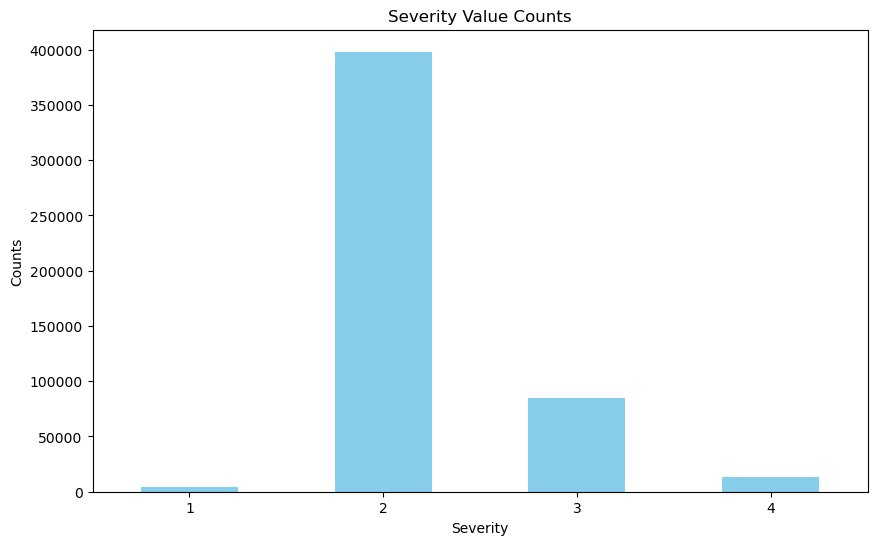

In [ ]:
counts = df['Severity'].value_counts()
severity_order = [1, 2, 3, 4]
counts = counts.reindex(severity_order)

# Create a bar plot
plt.figure(figsize=(10, 6))
counts.plot(kind='bar', color='skyblue')
plt.title('Severity Value Counts')
plt.xlabel('Severity')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.show()

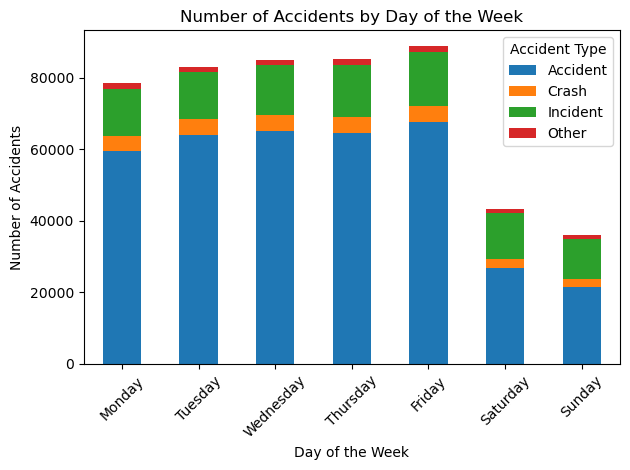

In [ ]:
# Plotting the graph for number of accidents in each day of the week

custom_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


grouped_data = df[df['Start_Weekday'].notna()].groupby(['Start_Weekday', 'Accident_type']).size().unstack(fill_value=0)
grouped_data = grouped_data.reindex(custom_order)  # Sort by custom order

grouped_data.plot(kind='bar', stacked=True)
plt.title('Number of Accidents by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.legend(title='Accident Type')
plt.tight_layout()
plt.show()

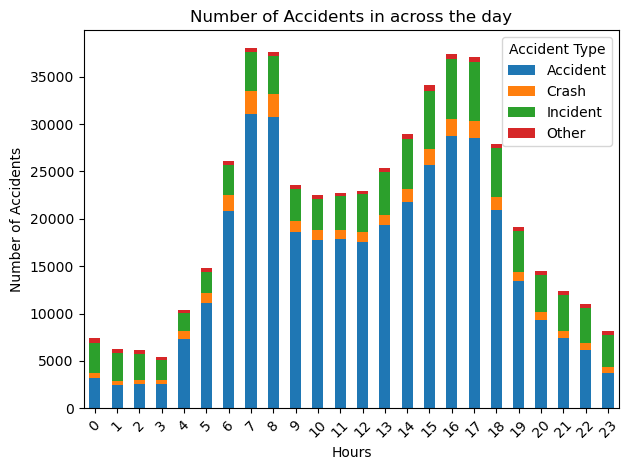

In [ ]:
# Plotting the graph

grouped_data = df[df['Start_Hour'].notna()].groupby(['Start_Hour', 'Accident_type']).size().unstack(fill_value=0)

grouped_data.plot(kind='bar', stacked=True)
plt.title('Number of Accidents in across the day')
plt.xlabel('Hours')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.legend(title='Accident Type')
plt.tight_layout()
plt.show()

In [ ]:
## Analysing the hour of the accidents on Weekends

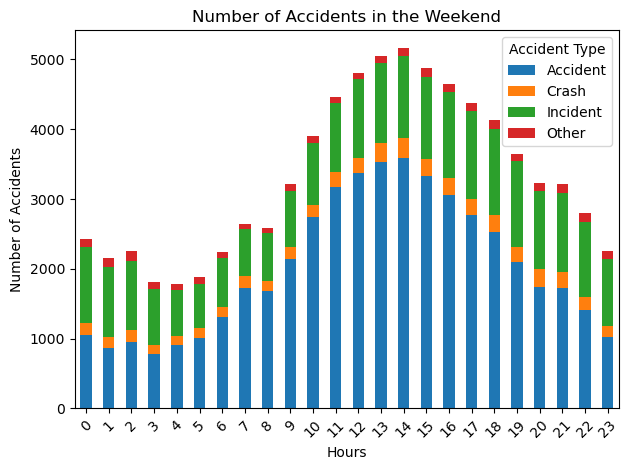

In [ ]:
df_weekend = df[df['Start_Weekday'].isin(['Saturday', 'Sunday'])]


grouped_data = df_weekend[df_weekend['Start_Hour'].notna()].groupby(['Start_Hour', 'Accident_type']).size().unstack(fill_value=0)

grouped_data.plot(kind='bar', stacked=True)
plt.title('Number of Accidents in the Weekend')
plt.xlabel('Hours')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.legend(title='Accident Type')
plt.tight_layout()
plt.show()

## Analysing the distribution of weather contion 

In [25]:
weather_counts = df['Weather_Condition'].value_counts()

# Calculate the percentage of values for each weather type
total_values = len(df)
weather_percentages = (weather_counts / total_values) * 100

# Create a DataFrame to display the percentage distribution
weather_distribution_df = pd.DataFrame({'Weather Condition': weather_percentages.index, 'Percentage (%)': weather_percentages.values})
weather_distribution_df = weather_distribution_df.sort_values(by='Percentage (%)', ascending=False)

# Display the percentage distribution in a table
weather_distribution_df.head(20)

,Weather Condition,Percentage (%)
0,Fair,33.2106
1,Mostly Cloudy,13.0796
2,Cloudy,10.6214
3,Clear,10.4758
4,Partly Cloudy,9.0250
5,Overcast,4.9802
6,Light Rain,4.5436
7,Scattered Clouds,2.6060
8,Light Snow,1.6466
9,Fog,1.2890


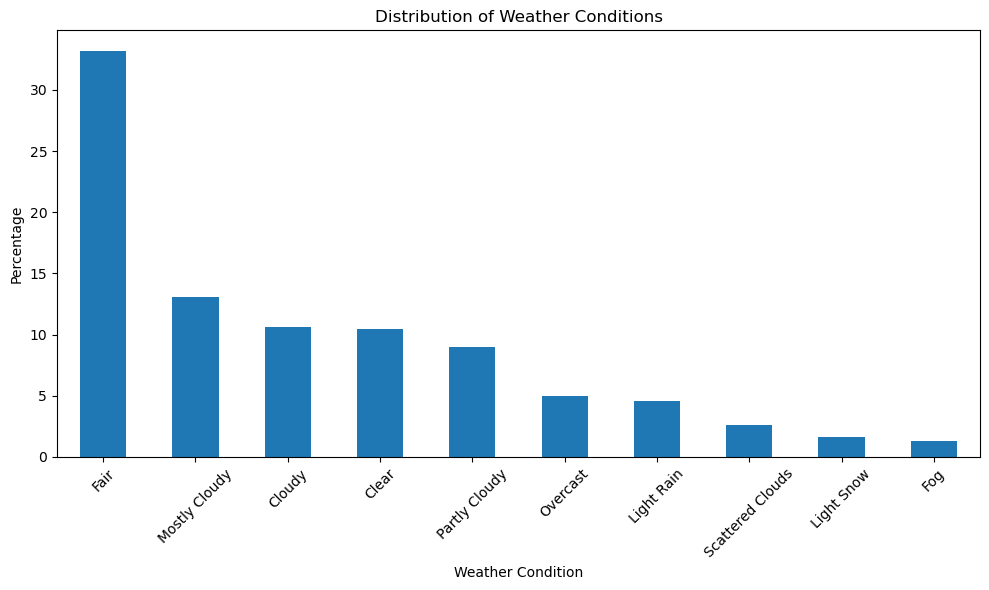

In [26]:
top_weather_counts = weather_distribution_df.head(10)

# Plotting the distribution of weather conditions
plt.figure(figsize=(10, 6))
top_weather_counts.set_index('Weather Condition')['Percentage (%)'].plot(kind='bar')
plt.title('Distribution of Weather Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
## Analysis for city

In [28]:
cities = df.City.unique()
len(cities)

9489

In [29]:
cities_by_accident = df.City.value_counts()
top20_city = cities_by_accident.head(20)

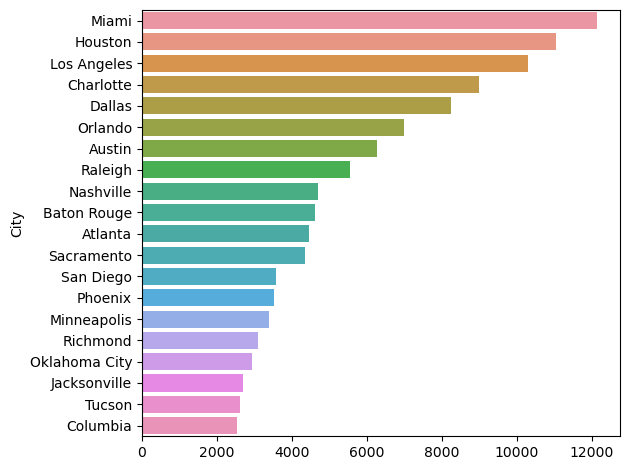

In [30]:
sns.barplot(y=top20_city.keys(),x=top20_city.values)
plt.tight_layout()

In [31]:
states = df.State.unique()
len(states)

49

In [32]:
states_by_accident = df.State.value_counts()
top20_state = states_by_accident.head(20)

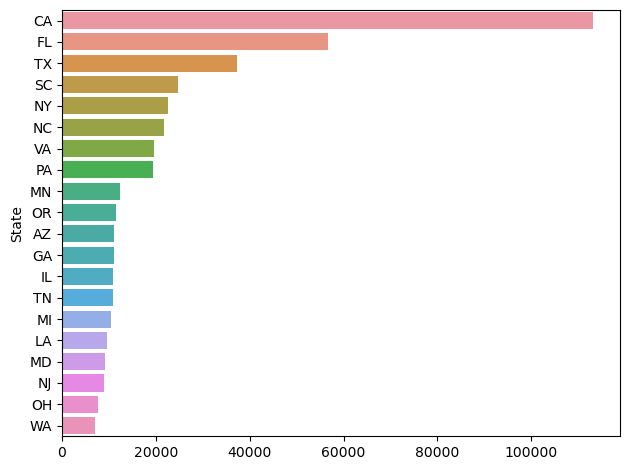

In [33]:
sns.barplot(y=top20_state.keys(),x=top20_state.values)
plt.tight_layout()

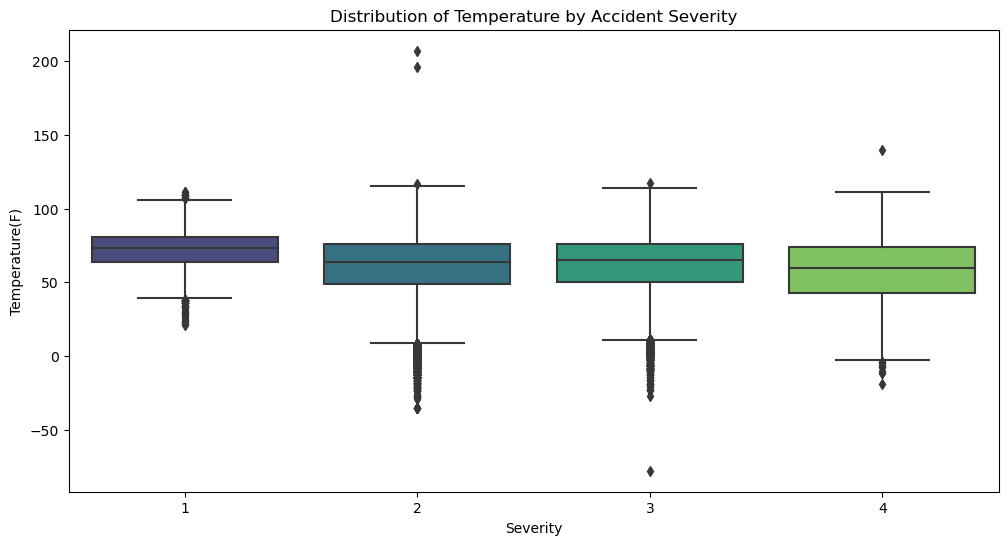

In [34]:
# Convert 'Severity' column to string
# Define the desired order of the severity levels
severity_order = [1, 2, 3, 4]

# Create a box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Severity', y='Temperature(F)', order=severity_order, palette='viridis')
plt.title('Distribution of Temperature by Accident Severity')
plt.xlabel('Severity')
plt.ylabel('Temperature(F)')
plt.show()

<Axes: ylabel='count'>

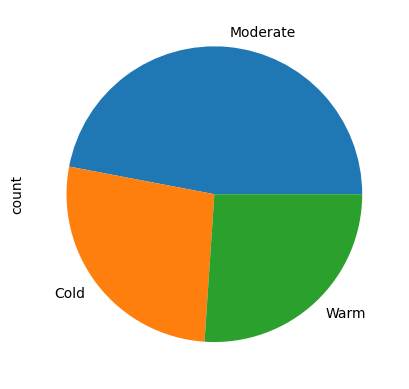

In [35]:
accidents_by_temperature = df['Temperature_Category'].value_counts()
df['Temperature_Category'].value_counts().plot(kind='pie')

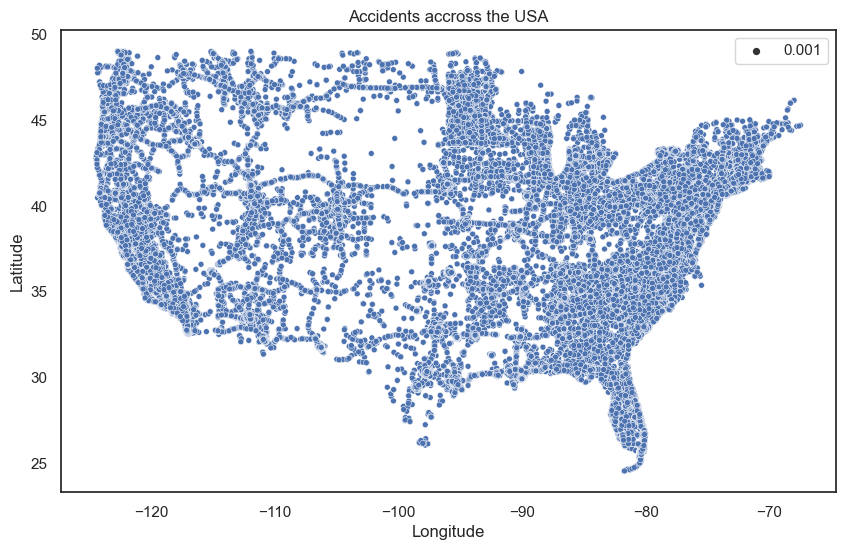

In [143]:
# Create a scatter plot using seaborn with the entire dataset
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Start_Lng'], y=df['Start_Lat'], size=0.001)

# Add titles and labels
plt.title('Accidents accross the USA')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

df_loc = df.loc[(~df.Start_Lat.isna()) & (~df.Start_Lng.isna())]

def create_map(df_loc, latitude, longitude, zoom, tiles='OpenStreetMap'):
    """
    Generate a Folium Map with clustered markers of accident locations.
    """
    world_map = folium.Map(location=[latitude, longitude], zoom_start=zoom, tiles=tiles)
    marker_cluster = MarkerCluster().add_to(world_map)

    # Iterate over the DataFrame rows and add each marker to the cluster
    for idx, row in df_loc.iterrows():
        folium.Marker(
            location=[row['Start_Lat'], row['Start_Lng']],
            # You can add more attributes to your marker here, such as a popup
            popup=f"Lat, Lng: {row['Start_Lat']}, {row['Start_Lng']}"
        ).add_to(marker_cluster)

    return world_map

map_us = create_map(df_loc, 39.50, -98.35, 4)
map_us

map_ny = create_map(
    df_loc, 41.8781,
    -87.6298,
    10, tiles="cartodbpositron")
map_ny

In [37]:
## Exploring other variables

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 20))

month_map = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

colors = [('#A6CEE3', '#1F78B4'), ('#B2DF8A', '#33A02C'), ('#FDBF6F', '#FF7F00'), ('#FB9A99', '#E31A1C'),
          ('#FDC086', '#FFD700'), ('#E5C494', '#8A6E45'), ('#FFFF99', '#1A9850'), ('#FDC3C3', '#800080'),
          ('#D9D9D9', '#737373'), ('#BC80BD', '#404040'), ('#CCEBC5', '#1B9E77'), ('#FFED6F', '#8DD3C7')]



count = 0

def func(pct, allvals):
    absolute = int(round(pct / 100 * np.sum(allvals), 2))
    return "{:.2f}%\n({:,d} Cases)".format(pct, absolute)

for i, ax in enumerate(axes.flatten()):
    month = i + 1
    size = list(df[df["Start_Month"] == month]["Is_Weekend"].value_counts())
    if len(size) != 2:
        size.append(0)

    labels = ['False', 'True']

    ax.pie(size, labels=labels, colors=colors[count],
           autopct=lambda pct: func(pct, size), labeldistance=1.1,
           textprops={'fontsize': 12}, explode=[0, 0.2])

    title = '\n Month {}'.format(month_map[month])

    ax.set_title(title, fontsize=18, color='grey')

    count += 1
    
plt.tight_layout()
plt.show()

In [38]:
column_name = 'Sunrise_Sunset'
value_counts = df[column_name].value_counts()
print(value_counts)

Sunrise_Sunset
Day      344967
Night    153550
Name: count, dtype: int64


In [39]:
column_name = 'Civil_Twilight'
value_counts = df[column_name].value_counts()
print(value_counts)

Civil_Twilight
Day      368274
Night    130243
Name: count, dtype: int64


In [40]:
#df.to_csv("cleanData.csv", index=False)

df_seatbelt = pd.read_html('https://en.wikipedia.org/wiki/Seat_belt_laws_in_the_United_States')[0]
df_seatbelt = df_seatbelt.drop(['Type of law','Date of first law','Who is covered','Base fine before fees'], axis = 1)
df_seatbelt = df_seatbelt.rename(columns = {'State, federal district, or territory':'State','Seat Belt Usage (2017) [7][note 2]':'Seatbelt'})
df_seatbelt = df_seatbelt.drop(52) ### Wake Island has no data.
df_seatbelt.sort_values(by = 'Seatbelt', ascending = False).head()

sns.set(style="white", context="talk")
fig, ax = plt.subplots(figsize=(16,10)) 
x = df_states_full['Seatbelt']
y = df_states_full['Severity']
ax = sns.regplot(x, y, 
                  data = df, scatter_kws = {"s": 250},
                  marker = "+", color = 'r')
ax.set(xlabel = "Seatbelt Useage (%)", ylabel = "Number of Accidents")
result = stats.linregress(x, y)
print("Slope: ", result.slope)
print("Intercept: ", result.intercept)
print("rvalue: ", result.rvalue)
print("pvalue: ", result.pvalue)
print("stderr: ", result.stderr)

In [42]:
dfProcessed = df.copy()

dfProcessed.drop(columns=["Start_Time", "End_Time", "Weather_Timestamp", "Street","Country", 'Description', "Timezone", "End_Lat", "End_Lng","Zipcode", "Airport_Code"], inplace=True)
dfProcessed.dropna(subset=['Wind_Chill(F)','Wind_Speed(mph)','Precipitation(in)'],inplace = True)

In [43]:
dfProcessed.shape

(500000, 37)

In [44]:
dfProcessed.columns.values

array(['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'City',
       'County', 'State', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
       'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight',
       'Start_Year', 'Start_Weekday', 'Start_Day', 'Start_Hour',
       'Start_Month', 'Accident_type', 'Temperature_Category'],
      dtype=object)

In [45]:
## Filling missing values:

In [46]:
dfProcessed.fillna(method='ffill', limit=2, inplace=True)
dfProcessed.fillna(method='bfill', limit=2, inplace=True)

In [47]:
dfProcessed.isnull().sum()

Severity                 0
Start_Lat                0
Start_Lng                0
Distance(mi)             0
City                     0
County                   0
State                    0
Temperature(F)           0
Humidity(%)              0
Pressure(in)             0
Visibility(mi)           0
Wind_Direction           0
Weather_Condition        0
Amenity                  0
Bump                     0
Crossing                 0
Give_Way                 0
Junction                 0
No_Exit                  0
Railway                  0
Roundabout               0
Station                  0
Stop                     0
Traffic_Calming          0
Traffic_Signal           0
Turning_Loop             0
Sunrise_Sunset           0
Civil_Twilight           0
Nautical_Twilight        0
Astronomical_Twilight    0
Start_Year               0
Start_Weekday            0
Start_Day                0
Start_Hour               0
Start_Month              0
Accident_type            0
Temperature_Category     0
d

In [48]:
dfProcessed['Weather_Condition'].unique()

array(['Fair', 'Wintry Mix', 'Light Rain', 'Cloudy', 'Mostly Cloudy',
       'Partly Cloudy', 'Clear', 'Scattered Clouds', 'Fog', 'Overcast',
       'Light Snow', 'T-Storm', 'Thunderstorms and Rain', 'Thunder',
       'Light Rain with Thunder', 'Rain', 'Showers in the Vicinity',
       'Mostly Cloudy / Windy', 'Heavy Rain', 'Cloudy / Windy',
       'Light Drizzle', 'Heavy T-Storm', 'Light Rain / Windy', 'Smoke',
       'Haze', 'Blowing Dust / Windy', 'N/A Precipitation',
       'Thunder in the Vicinity', 'Snow', 'Heavy Thunderstorms and Rain',
       'Shallow Fog', 'Light Freezing Drizzle', 'Fair / Windy',
       'Patches of Fog', 'Light Snow / Windy', 'Blowing Snow / Windy',
       'Thunderstorm', 'Drizzle', 'T-Storm / Windy',
       'Partly Cloudy / Windy', 'Heavy Rain / Windy',
       'Heavy Snow / Windy', 'Mist', 'Light Thunderstorms and Rain',
       'Rain / Windy', 'Light Freezing Rain', 'Heavy Snow',
       'Light Ice Pellets', 'Heavy T-Storm / Windy', 'Heavy Drizzle',
       'S

In [49]:
weather_bins = {
    'Clear': ['Clear', 'Fair'],
    'Cloudy': ['Cloudy', 'Mostly Cloudy', 'Partly Cloudy', 'Scattered Clouds'],
    'Rainy': ['Light Rain', 'Rain', 'Light Freezing Drizzle', 'Light Drizzle', 'Heavy Rain', 'Light Freezing Rain', 'Drizzle', 'Light Freezing Fog', 'Light Rain Showers', 'Showers in the Vicinity', 'T-Storm', 'Thunder', 'Patches of Fog', 'Heavy T-Storm', 'Heavy Thunderstorms and Rain', 'Funnel Cloud', 'Heavy T-Storm / Windy', 'Heavy Thunderstorms and Snow', 'Rain / Windy', 'Heavy Rain / Windy', 'Squalls', 'Heavy Ice Pellets', 'Thunder / Windy', 'Drizzle and Fog', 'T-Storm / Windy', 'Smoke / Windy', 'Haze / Windy', 'Light Drizzle / Windy', 'Widespread Dust / Windy', 'Wintry Mix', 'Wintry Mix / Windy', 'Light Snow with Thunder', 'Fog / Windy', 'Snow and Thunder', 'Sleet / Windy', 'Heavy Freezing Rain / Windy', 'Squalls / Windy', 'Light Rain Shower / Windy', 'Snow and Thunder / Windy', 'Light Sleet / Windy', 'Sand / Dust Whirlwinds', 'Mist / Windy', 'Drizzle / Windy', 'Duststorm', 'Sand / Dust Whirls Nearby', 'Thunder and Hail', 'Freezing Rain / Windy', 'Light Snow Shower / Windy', 'Partial Fog', 'Thunder / Wintry Mix / Windy', 'Patches of Fog / Windy', 'Rain and Sleet', 'Light Snow Grains', 'Partial Fog / Windy', 'Sand / Dust Whirlwinds / Windy', 'Heavy Snow with Thunder', 'Heavy Blowing Snow', 'Low Drifting Snow', 'Light Hail', 'Light Thunderstorm', 'Heavy Freezing Drizzle', 'Light Blowing Snow', 'Thunderstorms and Snow', 'Heavy Rain Showers', 'Rain Shower / Windy', 'Sleet and Thunder', 'Heavy Sleet and Thunder', 'Drifting Snow / Windy', 'Shallow Fog / Windy', 'Thunder and Hail / Windy', 'Heavy Sleet / Windy', 'Sand / Windy', 'Heavy Rain Shower / Windy', 'Blowing Snow Nearby', 'Blowing Sand', 'Heavy Rain Shower', 'Drifting Snow', 'Heavy Thunderstorms with Small Hail'],
    'Snowy': ['Light Snow', 'Snow', 'Light Snow / Windy', 'Snow Grains', 'Snow Showers', 'Snow / Windy', 'Light Snow and Sleet', 'Snow and Sleet', 'Light Snow and Sleet / Windy', 'Snow and Sleet / Windy'],
    'Windy': ['Blowing Dust / Windy', 'Fair / Windy', 'Mostly Cloudy / Windy', 'Light Rain / Windy', 'T-Storm / Windy', 'Blowing Snow / Windy', 'Freezing Rain / Windy', 'Light Snow and Sleet / Windy', 'Sleet and Thunder / Windy', 'Blowing Snow Nearby', 'Heavy Rain Shower / Windy'],
    'Hail': ['Hail'],
    'Volcanic Ash': ['Volcanic Ash'],
    'Tornado': ['Tornado']
}

def map_weather_to_bins(weather):
    for bin_name, bin_values in weather_bins.items():
        if weather in bin_values:
            return bin_name
    return 'Other' 

dfProcessed['Weather_Bin'] = dfProcessed['Weather_Condition'].apply(map_weather_to_bins)
dfProcessed['Weather_Bin']

0          Clear
1          Clear
2          Clear
3          Rainy
4          Clear
           ...  
499995     Rainy
499996    Cloudy
499997     Clear
499998     Clear
499999     Clear
Name: Weather_Bin, Length: 500000, dtype: object

In [50]:
dfProcessed.drop(columns=['Weather_Condition'], inplace=True)

In [51]:
df['End_Time'] = pd.to_datetime(df['End_Time'],format='mixed')
df['Start_Time'] = pd.to_datetime(df['Start_Time'],format='mixed')
dfProcessed['Accident_Duration'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60.0

In [52]:
def categorize_rush_hour(start_time):
    hour = start_time.hour
    
    try:        
        if 6 <= int(hour) < 10:  
            return 'Yes'
        elif 15 <= int(hour) < 19: 
            return 'Yes'
        else:
            return 'No'
    except ValueError:
        return 'Invalid'

dfProcessed['Is_Rush_Hour'] = df['Start_Time'].apply(categorize_rush_hour)

In [53]:
dfProcessed.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),City,County,State,Temperature(F),Humidity(%),Pressure(in),...,Start_Year,Start_Weekday,Start_Day,Start_Hour,Start_Month,Accident_type,Temperature_Category,Weather_Bin,Accident_Duration,Is_Rush_Hour
0,2,30.641211,-91.153481,0.000,Zachary,East Baton Rouge,LA,77.0,62.0,29.92,...,2019,Wednesday,12,10,6,Accident,Warm,Clear,45.033333,No
1,2,38.990562,-77.399070,0.056,Sterling,Loudoun,VA,45.0,48.0,29.91,...,2022,Saturday,3,23,12,Incident,Cold,Clear,139.650000,No
2,2,34.661189,-120.492822,0.022,Lompoc,Santa Barbara,CA,68.0,73.0,29.79,...,2022,Saturday,20,13,8,Accident,Moderate,Clear,129.750000,No
3,2,43.680592,-92.993317,1.054,Austin,Mower,MN,27.0,86.0,28.49,...,2022,Monday,21,17,2,Incident,Cold,Rainy,120.316667,Yes
4,2,35.395484,-118.985176,0.046,Bakersfield,Kern,CA,42.0,34.0,29.77,...,2020,Friday,4,1,12,Other,Cold,Clear,147.150000,No


In [54]:
dfProcessed.shape

(500000, 39)

In [55]:

sampled_dff = dfProcessed.copy()

sampled_dff.dropna(inplace=True)

categorical_cols = sampled_dff.select_dtypes(include=['object','bool','category']).columns
label_encoder = LabelEncoder()
for col in categorical_cols:
    sampled_dff[col] = label_encoder.fit_transform(sampled_dff[col])
    
X = sampled_dff.drop('Severity', axis=1)
y= sampled_dff['Severity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

rf_classifier = RandomForestClassifier()

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

# print(classification_task(rf_classifier,X_train, y_train ,X_test,y_test, y_pred,'rf'))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Accuracy: 0.86
Confusion Matrix:
[[   549    646     93      4]
 [   141 114928   4299    142]
 [    44  11896  13266     53]
 [    13   3211    339    376]]
Classification Report:
              precision    recall  f1-score   support

           1       0.73      0.42      0.54      1292
           2       0.88      0.96      0.92    119510
           3       0.74      0.53      0.61     25259
           4       0.65      0.10      0.17      3939

    accuracy                           0.86    150000
   macro avg       0.75      0.50      0.56    150000
weighted avg       0.85      0.86      0.84    150000



## MODEL BUILDING

In [56]:
df_numerical = dfProcessed.select_dtypes(include=['int64','float64'])

<Axes: >

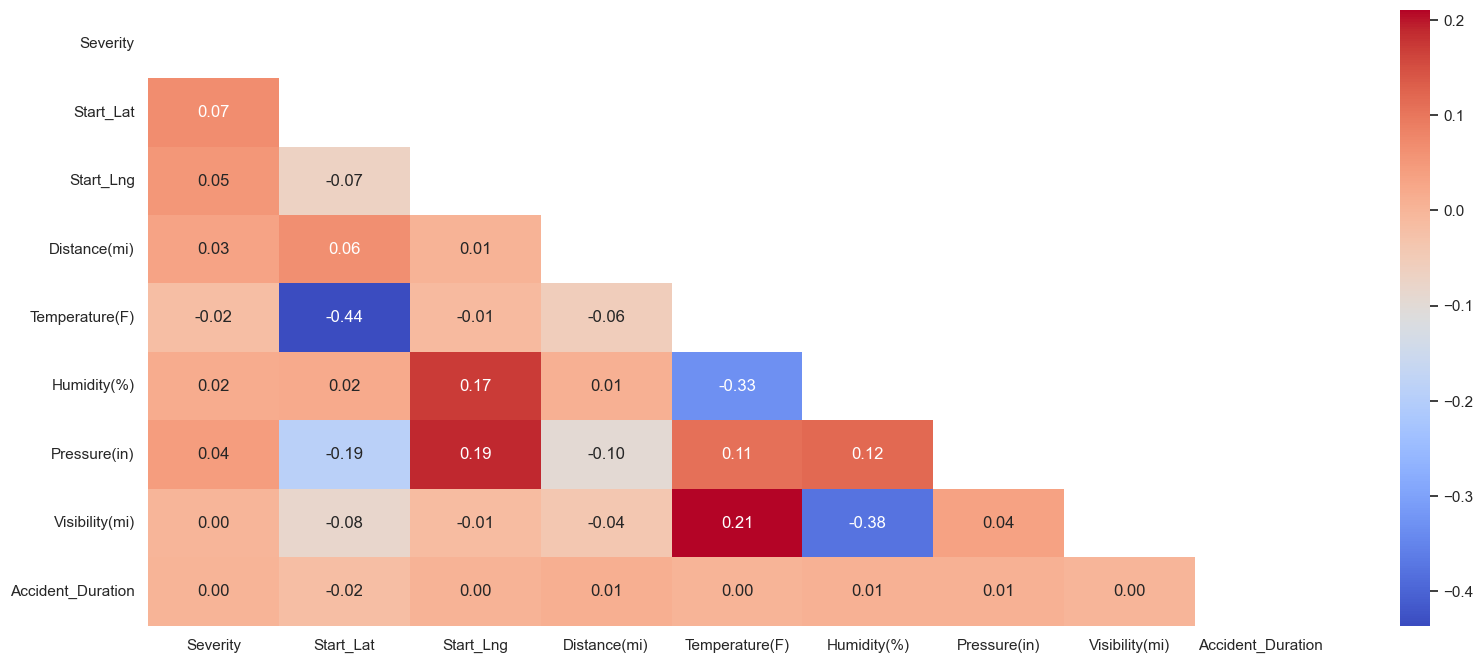

In [57]:
plt.figure(figsize=(19, 8))
sns.set(style="white") 
mask = np.triu(df_numerical.corr()) 
sns.heatmap(data=df_numerical.corr(), annot=True, fmt=".2f", cmap='coolwarm', mask=mask)

In [58]:
dfEncoded = dfProcessed.copy()
columns_to_encode = dfEncoded.select_dtypes(include=['bool','object','category']).columns

# Dictionary to store LabelEncoders for each column
label_encoders = {}
# Loop to apply LabelEncoder to each column
for col in columns_to_encode:
    # Create a new LabelEncoder for the column
    le = LabelEncoder()

    # Fit and transform the data, then inverse transform it
    dfEncoded[col] = le.fit_transform(dfEncoded[col])

    # Store the encoder in the dictionary
    label_encoders[col] = le

In [59]:
dfEncoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 39 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Severity               500000 non-null  int64  
 1   Start_Lat              500000 non-null  float64
 2   Start_Lng              500000 non-null  float64
 3   Distance(mi)           500000 non-null  float64
 4   City                   500000 non-null  int64  
 5   County                 500000 non-null  int64  
 6   State                  500000 non-null  int64  
 7   Temperature(F)         500000 non-null  float64
 8   Humidity(%)            500000 non-null  float64
 9   Pressure(in)           500000 non-null  float64
 10  Visibility(mi)         500000 non-null  float64
 11  Wind_Direction         500000 non-null  int64  
 12  Amenity                500000 non-null  int64  
 13  Bump                   500000 non-null  int64  
 14  Crossing               500000 non-nu

## VIF Test

In [60]:
sampled_df = dfEncoded.sample(frac=0.1, random_state=42)

In [61]:
X = sampled_df.drop('Severity', axis=1)
y= sampled_df['Severity']
X.shape

(50000, 38)

In [62]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 104241 to 265640
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Start_Lat              50000 non-null  float64
 1   Start_Lng              50000 non-null  float64
 2   Distance(mi)           50000 non-null  float64
 3   City                   50000 non-null  int64  
 4   County                 50000 non-null  int64  
 5   State                  50000 non-null  int64  
 6   Temperature(F)         50000 non-null  float64
 7   Humidity(%)            50000 non-null  float64
 8   Pressure(in)           50000 non-null  float64
 9   Visibility(mi)         50000 non-null  float64
 10  Wind_Direction         50000 non-null  int64  
 11  Amenity                50000 non-null  int64  
 12  Bump                   50000 non-null  int64  
 13  Crossing               50000 non-null  int64  
 14  Give_Way               50000 non-null  int64  
 15  J

In [63]:
vif_data = pd.DataFrame()
X_numerical = X.select_dtypes(include=['int64','float64'])
vif_data["Severity"] = X_numerical.columns
vif_data["VIF"] = [variance_inflation_factor(X_numerical.values, i) for i in range(X_numerical.shape[1])]

/Users/suriya/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


In [64]:
vif_data.sort_values(by='VIF',ascending= False)

,Severity,VIF
8,Pressure(in),165.438893
0,Start_Lat,67.957927
6,Temperature(F),54.820642
1,Start_Lng,37.762751
9,Visibility(mi),18.385500
7,Humidity(%),13.651208
30,Temperature_Category,12.667794
25,Civil_Twilight,10.803396
26,Nautical_Twilight,9.483456
24,Sunrise_Sunset,7.233739


In [65]:
#mutual information
from sklearn.feature_selection import mutual_info_regression

# Perform feature selection using mutual information
num_features_to_select = 10  # Number of features you want to select
selector = SelectKBest(score_func=mutual_info_regression, k=num_features_to_select)
X_selected = selector.fit_transform(X, y)

# Get the selected feature indices
selected_feature_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X.columns[selected_feature_indices]

# Print selected feature names
print("Selected Features:")
print(sorted(selected_feature_names))
mutualSelected = X[selected_feature_names]
mutualSelected.head()

Selected Features:
['Accident_Duration', 'Accident_type', 'City', 'County', 'Distance(mi)', 'Start_Lat', 'Start_Lng', 'Start_Year', 'State', 'Temperature(F)']


,Start_Lat,Start_Lng,Distance(mi),City,County,State,Temperature(F),Start_Year,Accident_type,Accident_Duration
104241,39.115330,-108.544750,0.000,3299,930,4,37.0,2019,0,29.250000
199676,35.115662,-81.069710,0.000,1617,1603,38,72.0,2019,0,91.116667
140199,30.238410,-97.738505,0.953,341,1449,41,75.0,2022,2,270.000000
132814,40.153828,-75.419403,0.000,5984,964,36,89.6,2018,0,29.483333
408697,38.114959,-77.517769,0.868,9357,1333,43,41.0,2021,2,78.416667


In [66]:
# Wrapper select
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression  # You can replace this with any estimator of your choice

# Initialize your estimator (model)
estimator = LinearRegression()  # You can replace this with any estimator of your choice

# Initialize RFE with the estimator and desired number of features to select
num_features_to_select = 10  # Number of features you want to select
selector = RFE(estimator, n_features_to_select=num_features_to_select)

# Fit RFE to your data
selector.fit(X, y)

# Get the selected feature indices
selected_feature_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X.columns[selected_feature_indices]

# Print selected feature names
print("Selected Features:")
print(sorted(selected_feature_names))
wrapSelected = X[selected_feature_names]
wrapSelected.head()

Selected Features:
['Amenity', 'Bump', 'Crossing', 'Railway', 'Roundabout', 'Start_Year', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']


,Amenity,Bump,Crossing,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Start_Year
104241,0,0,0,0,0,0,0,0,0,2019
199676,0,0,0,0,0,0,0,0,0,2019
140199,0,0,0,0,0,0,0,0,0,2022
132814,0,0,0,0,0,0,0,0,0,2018
408697,0,0,0,0,0,0,0,0,0,2021


In [68]:
#Univariate feature selection
from sklearn.feature_selection import SelectKBest, f_regression  # You can replace f_regression with any other suitable scoring function

# Initialize SelectKBest with the desired scoring function and number of features to select
num_features_to_select = 10  # Number of features you want to select
selector = SelectKBest(score_func=f_regression, k=num_features_to_select)

# Fit SelectKBest to your data
selector.fit(X, y)

# Get the selected feature indices
selected_feature_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = X.columns[selected_feature_indices]

# Print selected feature names
print("Selected Features:")
print(sorted(selected_feature_names))
uniVarSelected = X[selected_feature_names]
uniVarSelected.head()

Selected Features:
['Accident_type', 'County', 'Crossing', 'Junction', 'Start_Lat', 'Start_Lng', 'Start_Year', 'Station', 'Stop', 'Traffic_Signal']


,Start_Lat,Start_Lng,County,Crossing,Junction,Station,Stop,Traffic_Signal,Start_Year,Accident_type
104241,39.115330,-108.544750,930,0,0,0,0,0,2019,0
199676,35.115662,-81.069710,1603,0,0,0,0,0,2019,0
140199,30.238410,-97.738505,1449,0,0,0,0,0,2022,2
132814,40.153828,-75.419403,964,0,0,0,0,0,2018,0
408697,38.114959,-77.517769,1333,0,0,0,0,0,2021,2


In [69]:
## RandomForest

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)  

y_pred = rf_classifier.predict(X_test)

# print(classification_task(rf_classifier,X_train, y_train ,X_test,y_test, y_pred,'rf'))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion_mat)

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Accuracy: 0.83
Confusion Matrix:
[[   17   103     5     2]
 [    7 11543   395     8]
 [    3  1635   893     3]
 [    0   358    17    11]]
Classification Report:
              precision    recall  f1-score   support

           1       0.63      0.13      0.22       127
           2       0.85      0.97      0.90     11953
           3       0.68      0.35      0.46      2534
           4       0.46      0.03      0.05       386

    accuracy                           0.83     15000
   macro avg       0.65      0.37      0.41     15000
weighted avg       0.81      0.83      0.80     15000



In [72]:
## Class imbalance

In [142]:
sam= RandomUnderSampler(random_state=0)
X_resampled_under , y_resampled_under = sam.fit_resample(X,y)
y_resampled_under.value_counts()

Severity
1    435
2    435
3    435
4    435
Name: count, dtype: int64

In [74]:
X_resampled_under, X_test_resampled, y_resampled_under, y_test_resampled = train_test_split(X_resampled_under, y_resampled_under, test_size=0.30, random_state=42)

In [77]:
dt_classifier = DecisionTreeClassifier()

dt_classifier.fit(X_resampled_under, y_resampled_under)
y_pred = dt_classifier.predict(X_test)

Accuracy: 0.52
              precision    recall  f1-score   support

           1       0.13      0.99      0.23       127
           2       0.90      0.49      0.63     11953
           3       0.33      0.59      0.43      2534
           4       0.09      0.70      0.16       386

    accuracy                           0.52     15000
   macro avg       0.36      0.69      0.36     15000
weighted avg       0.78      0.52      0.58     15000



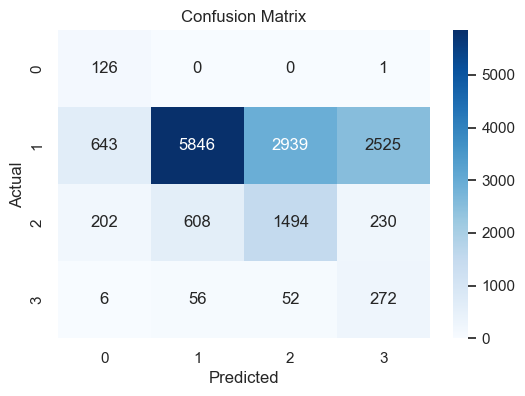

In [78]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Classification models

In [80]:
def classification_task( model,X_train_scaled, y_train ,X_test_scaled ,y_test, predic,model_name):
 
    perf_df=pd.DataFrame({'Train_Score':model.score(X_train_scaled,y_train),"Test_Score":model.score(X_test_scaled,y_test),
                       "Precision_Score":precision_score(y_test,predic,average='weighted'),"Recall_Score":recall_score(y_test,predic,average='weighted'),
                       "F1_Score":f1_score(y_test,predic,average='weighted') , "accuracy":accuracy_score(y_test,predic)}, index=[model_name])
    return perf_df

In [87]:
rf_classifier = RandomForestClassifier(random_state=42)

rf_classifier.fit(X_train, y_train)
from sklearn.metrics import precision_score,recall_score,f1_score
y_pred = rf_classifier.predict(X_test)
Eval_Rf= classification_task(rf_classifier,X_train, y_train ,X_test ,y_test, y_pred ,'Random Forest')
Eval_Rf

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
Random Forest,0.999943,0.830867,0.808482,0.830867,0.799988,0.830867


Accuracy: 0.83


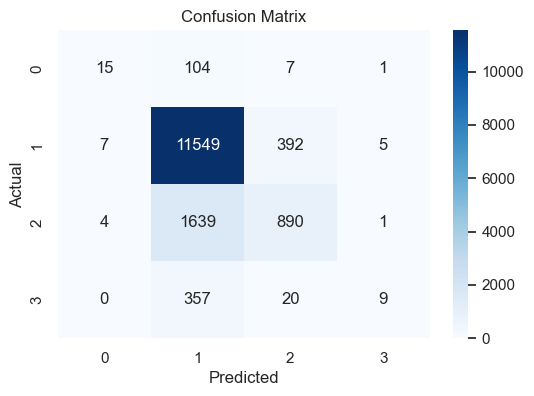

Classification Report:
              precision    recall  f1-score   support

           1       0.58      0.12      0.20       127
           2       0.85      0.97      0.90     11953
           3       0.68      0.35      0.46      2534
           4       0.56      0.02      0.04       386

    accuracy                           0.83     15000
   macro avg       0.67      0.36      0.40     15000
weighted avg       0.81      0.83      0.80     15000



In [88]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

In [89]:
## Decision tree
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_resampled_under, y_resampled_under)
y_pred = dt_classifier.predict(X_test_resampled)
Eval_Dt=classification_task(dt_classifier,X_resampled_under, y_resampled_under ,X_test_resampled ,y_test_resampled, y_pred,'Decision Trees')
Eval_Dt

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
Decision Trees,1.0,0.624521,0.625914,0.624521,0.623569,0.624521


Accuracy: 0.62


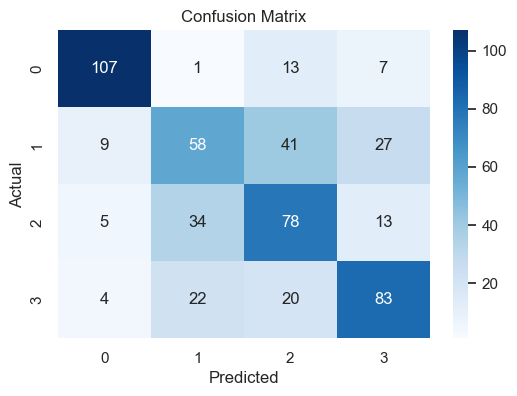

Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.84      0.85       128
           2       0.50      0.43      0.46       135
           3       0.51      0.60      0.55       130
           4       0.64      0.64      0.64       129

    accuracy                           0.62       522
   macro avg       0.63      0.63      0.63       522
weighted avg       0.63      0.62      0.62       522



In [90]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

### KNN

In [91]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled_under)
X_test_scaled = scaler.transform(X_test_resampled)

In [94]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_scaled, y_resampled_under)
y_pred = knn_classifier.predict(X_test_scaled)
Eval_KNN=classification_task(knn_classifier,X_train_scaled, y_resampled_under ,X_test_scaled ,y_test_resampled, y_pred,'KNN')
Eval_KNN

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
KNN,0.632184,0.408046,0.420429,0.408046,0.390408,0.408046


Accuracy: 0.41


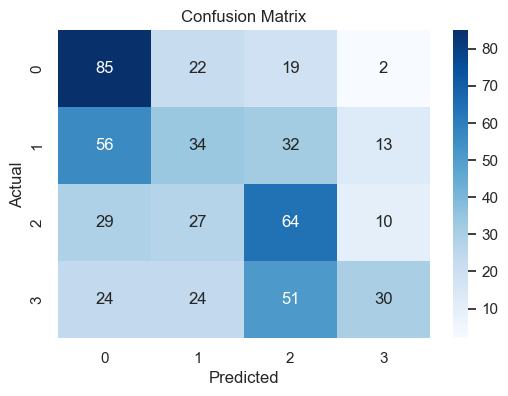

Classification Report:
              precision    recall  f1-score   support

           1       0.44      0.66      0.53       128
           2       0.32      0.25      0.28       135
           3       0.39      0.49      0.43       130
           4       0.55      0.23      0.33       129

    accuracy                           0.41       522
   macro avg       0.42      0.41      0.39       522
weighted avg       0.42      0.41      0.39       522



In [95]:
accuracy = accuracy_score(y_test_resampled, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_resampled, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test_resampled, y_pred)
print("Classification Report:")
print(class_report)

In [96]:
## Naive beyes

In [97]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_resampled_under, y_resampled_under)
y_pred = nb_classifier.predict(X_test_scaled)
Eval_nb=classification_task(nb_classifier,X_resampled_under, y_resampled_under ,X_test_resampled ,y_test_resampled, y_pred,'Naive Bayes')
Eval_nb

/Users/suriya/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
/Users/suriya/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
Naive Bayes,0.472906,0.436782,0.061071,0.247126,0.09794,0.247126


Accuracy: 0.25


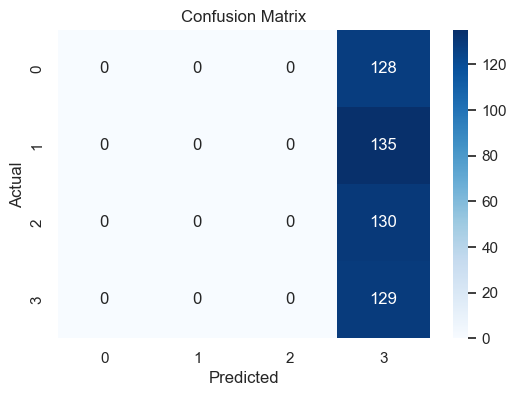

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       128
           2       0.00      0.00      0.00       135
           3       0.00      0.00      0.00       130
           4       0.25      1.00      0.40       129

    accuracy                           0.25       522
   macro avg       0.06      0.25      0.10       522
weighted avg       0.06      0.25      0.10       522



/Users/suriya/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suriya/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/suriya/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [98]:
accuracy = accuracy_score(y_test_resampled, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_resampled, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test_resampled, y_pred)
print("Classification Report:")
print(class_report)

In [99]:
##XGBOOST

xgb_classifier = XGBClassifier(objective='multi:softmax',random_state=42)
xgb_classifier.fit(X_resampled_under, y_resampled_under-1 )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [100]:
y_pred = xgb_classifier.predict(X_test_resampled)
Eval_xgb=classification_task(xgb_classifier,X_resampled_under, y_resampled_under-1 ,X_test_resampled,y_test_resampled-1, y_pred,'XGBoost')
Eval_xgb

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
XGBoost,1.0,0.724138,0.721084,0.724138,0.715435,0.724138


Accuracy: 0.72


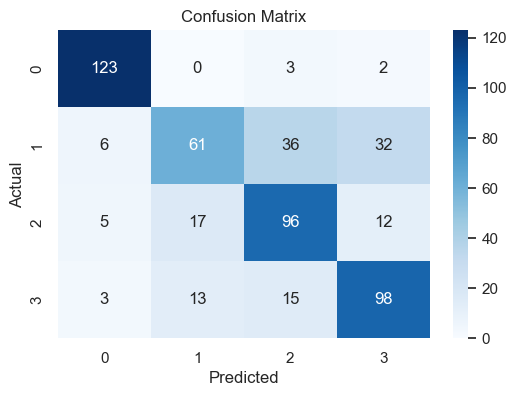

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       128
           1       0.67      0.45      0.54       135
           2       0.64      0.74      0.69       130
           3       0.68      0.76      0.72       129

    accuracy                           0.72       522
   macro avg       0.72      0.73      0.72       522
weighted avg       0.72      0.72      0.72       522



In [101]:
accuracy = accuracy_score(y_test_resampled-1, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_resampled-1, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test_resampled-1, y_pred)
print("Classification Report:")
print(class_report)

In [104]:
## ADABoost
ada_classifier = AdaBoostClassifier(random_state=42)
ada_classifier.fit(X_resampled_under, y_resampled_under)

AdaBoostClassifier(random_state=42)

In [105]:
y_pred = ada_classifier.predict(X_test_resampled)
Eval_ada=classification_task(ada_classifier,X_resampled_under, y_resampled_under ,X_test_resampled,y_test_resampled, y_pred,'ADABoost')
Eval_ada

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
ADABoost,0.666667,0.649425,0.64191,0.649425,0.639489,0.649425


Accuracy: 0.65


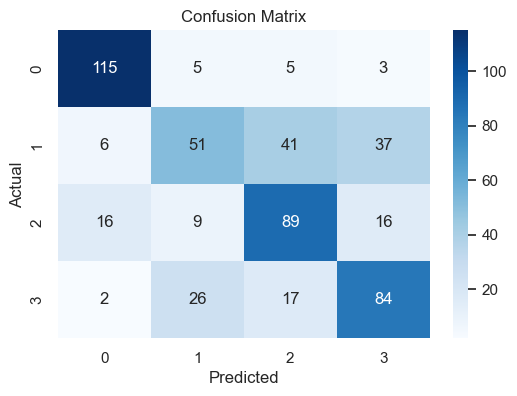

Classification Report:
              precision    recall  f1-score   support

           1       0.83      0.90      0.86       128
           2       0.56      0.38      0.45       135
           3       0.59      0.68      0.63       130
           4       0.60      0.65      0.62       129

    accuracy                           0.65       522
   macro avg       0.64      0.65      0.64       522
weighted avg       0.64      0.65      0.64       522



In [106]:
accuracy = accuracy_score(y_test_resampled, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_resampled, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test_resampled, y_pred)
print("Classification Report:")
print(class_report)

In [107]:
## Voting classifer

In [114]:
voting_classifier = VotingClassifier(estimators=[
    ('ada', ada_classifier),
    ('dt_classifier',dt_classifier),
    ('rf_classifier',rf_classifier),
    ('xgb', xgb_classifier)
], voting='soft') 

voting_classifier.fit(X_train, y_train)

VotingClassifier(estimators=[('ada', AdaBoostClassifier(random_state=42)),
                             ('dt_classifier',
                              DecisionTreeClassifier(random_state=42)),
                             ('rf_classifier',
                              RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_ro...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softmax', ...))],
                 voting='soft')

In [115]:

y_pred = voting_classifier.predict(X_test)

Eval_voting=classification_task(voting_classifier,X_train, y_train ,X_test,y_test, y_pred,'voting')
Eval_voting

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
voting,0.999971,0.820133,0.801087,0.820133,0.807799,0.820133


Accuracy: 0.82


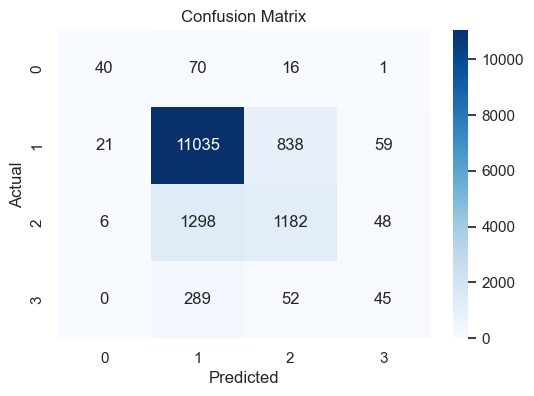

Classification Report:
              precision    recall  f1-score   support

           1       0.60      0.31      0.41       127
           2       0.87      0.92      0.90     11953
           3       0.57      0.47      0.51      2534
           4       0.29      0.12      0.17       386

    accuracy                           0.82     15000
   macro avg       0.58      0.46      0.50     15000
weighted avg       0.80      0.82      0.81     15000



In [116]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

In [118]:
defaultModel = pd.concat([Eval_KNN, Eval_voting , Eval_ada , Eval_xgb ,Eval_Rf,Eval_Dt,Eval_nb])

defaultModel

,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
KNN,0.632184,0.408046,0.420429,0.408046,0.390408,0.408046
voting,0.999971,0.820133,0.801087,0.820133,0.807799,0.820133
ADABoost,0.666667,0.649425,0.641910,0.649425,0.639489,0.649425
XGBoost,1.000000,0.724138,0.721084,0.724138,0.715435,0.724138
Random Forest,0.999943,0.830867,0.808482,0.830867,0.799988,0.830867
Decision Trees,1.000000,0.624521,0.625914,0.624521,0.623569,0.624521
Naive Bayes,0.472906,0.436782,0.061071,0.247126,0.097940,0.247126


## Hyperparameter tuning

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_d

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.2s
[CV

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.4s
[C

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6; total time=   0.4s
[CV

[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=1.0; total time=   

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.2s
[CV

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.2s
[CV

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6; total time=   0.4s
[CV

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.4s
[C

[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.2, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.6; total time=   0.2s
[C

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] EN

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END 

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] E

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] E

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=50, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.2s
[CV

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.6; total time=   0.5s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.8s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.9s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] E

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END c

[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[C

         Train_Score  Test_Score  Precision_Score  Recall_Score  F1_Score  \
XGBoost     0.965517    0.722222         0.717031      0.722222  0.715961   

         accuracy  
XGBoost  0.722222  
Accuracy: 0.72


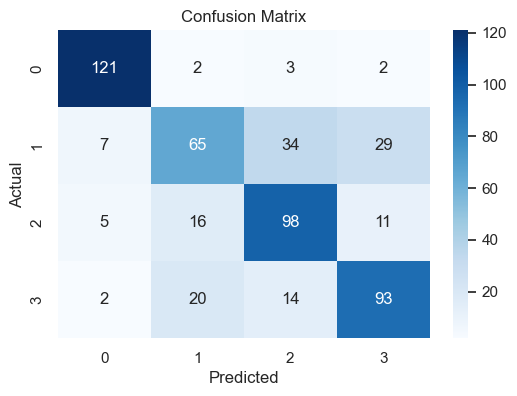

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       128
           1       0.63      0.48      0.55       135
           2       0.66      0.75      0.70       130
           3       0.69      0.72      0.70       129

    accuracy                           0.72       522
   macro avg       0.72      0.73      0.72       522
weighted avg       0.72      0.72      0.72       522

Best Hyperparameters found by GridSearchCV:
{'colsample_bytree': 1.0, 'gamma': 0.3, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.6; total time=   1.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0; total time=   1.2s
[CV] E

[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.6; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=  

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.2s
[CV] END col

[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.6; total time=   0.6s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.2, max_depth=5, n_estimators=50, subsample=0.8; total time=   0.1s
[CV] END c

In [120]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of boosting rounds
    'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
    'max_depth': [3, 5, 7],  # Maximum depth of a tree
    'subsample': [0.6, 0.8, 1.0],  # Fraction of samples used for fitting individual trees
    'colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features used for each tree
    'gamma': [0, 0.1, 0.3]  # Minimum loss reduction required to make a further partition on a leaf node
}

# Instantiate the XGBClassifier
xgb_classifier = XGBClassifier(objective='multi:softmax', random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, 
                           cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_resampled_under, y_resampled_under-1)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred = best_model.predict(X_test_resampled)




In [122]:
Eval_xgb = classification_task(best_model, X_resampled_under, y_resampled_under-1, 
                               X_test_resampled, y_test_resampled-1, y_pred, 'XGBoost')

# Print evaluation results
print(Eval_xgb)

# Print Classification Report
class_report = classification_report(y_test_resampled-1, y_pred)
print("Classification Report:")
print(class_report)

# Print Best Hyperparameters
print("Best Hyperparameters found by GridSearchCV:")
print(best_params)

         Train_Score  Test_Score  Precision_Score  Recall_Score  F1_Score  \
XGBoost     0.965517    0.722222         0.717031      0.722222  0.715961   

         accuracy  
XGBoost  0.722222  
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       128
           1       0.63      0.48      0.55       135
           2       0.66      0.75      0.70       130
           3       0.69      0.72      0.70       129

    accuracy                           0.72       522
   macro avg       0.72      0.73      0.72       522
weighted avg       0.72      0.72      0.72       522

Best Hyperparameters found by GridSearchCV:
{'colsample_bytree': 1.0, 'gamma': 0.3, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.6}


Accuracy: 0.72


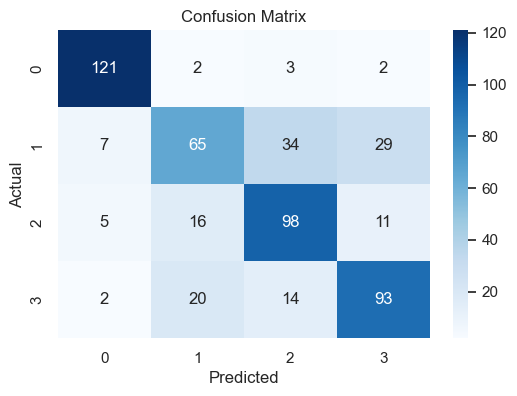

In [123]:
# Accuracy
accuracy = accuracy_score(y_test_resampled-1, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_resampled-1, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [124]:
#KNN hyperparamter tuning

In [125]:
# Define the parameter grid for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metric
}

# Instantiate the KNeighborsClassifier
knn_classifier = KNeighborsClassifier()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, 
                           cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_resampled_under)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred = best_model.predict(X_test_scaled)



Fitting 5 folds for each of 30 candidates, totalling 150 fits


     Train_Score  Test_Score  Precision_Score  Recall_Score  F1_Score  \
KNN          1.0         0.5         0.492251           0.5  0.481165   

     accuracy  
KNN       0.5  
Accuracy: 0.50


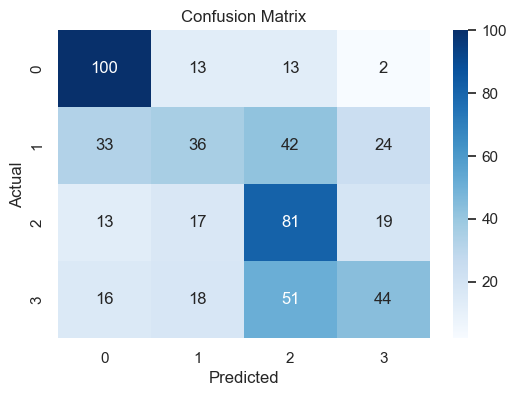

Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.78      0.69       128
           2       0.43      0.27      0.33       135
           3       0.43      0.62      0.51       130
           4       0.49      0.34      0.40       129

    accuracy                           0.50       522
   macro avg       0.49      0.50      0.48       522
weighted avg       0.49      0.50      0.48       522

Best Hyperparameters found by GridSearchCV:
{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}


In [126]:
Eval_KNN = classification_task(best_model, X_train_scaled, y_resampled_under, 
                               X_test_scaled, y_test_resampled, y_pred, 'KNN')
# Print evaluation results
print(Eval_KNN)

# Accuracy
accuracy = accuracy_score(y_test_resampled, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_resampled, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report
class_report = classification_report(y_test_resampled, y_pred)
print("Classification Report:")
print(class_report)

# Print Best Hyperparameters
print("Best Hyperparameters found by GridSearchCV:")
print(best_params)

In [139]:
# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'random_state': [42]
}

# Instantiate RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Instantiate GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search_rf.fit(X_resampled_under, y_resampled_under)

# Get the best parameters and the best model
best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_

# Predict on the test set using the best model
y_pred_rf = best_model_rf.predict(X_test_scaled)



Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/suriya/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.41


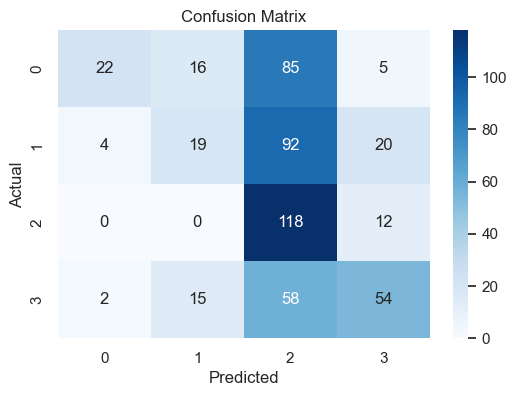

Classification Report:
              precision    recall  f1-score   support

           1       0.79      0.17      0.28       128
           2       0.38      0.14      0.21       135
           3       0.33      0.91      0.49       130
           4       0.59      0.42      0.49       129

    accuracy                           0.41       522
   macro avg       0.52      0.41      0.37       522
weighted avg       0.52      0.41      0.37       522

Best Hyperparameters found by GridSearchCV:
{'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300, 'random_state': 42}


In [140]:
# Calculate accuracy
accuracy_rf = accuracy_score(y_test_resampled, y_pred_rf)

# Print the accuracy
print(f"Accuracy: {accuracy_rf:.2f}")

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_resampled, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Classification report
class_report_rf = classification_report(y_test_resampled, y_pred_rf)
print("Classification Report:")
print(class_report_rf)

# Print Best Hyperparameters
print("Best Hyperparameters found by GridSearchCV:")
print(best_params_rf)

In [141]:
# Task
rf_Tune = classification_task(best_model_rf, X_train_scaled, y_resampled_under, 
                                                            X_test_scaled, y_test_resampled, y_pred_rf, 'RF')
rf_Tune

/Users/suriya/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/suriya/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,Train_Score,Test_Score,Precision_Score,Recall_Score,F1_Score,accuracy
RF,0.406404,0.408046,0.520837,0.408046,0.365286,0.408046


[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100, random_state=42; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200, random_state=42; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100, random_state=42; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200, random_state=42; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200, random_state=42; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_s

[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=42; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300, random_state=42; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=42; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300, random_state=42; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=300, random_state=42; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=42; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_s

[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=42; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300, random_state=42; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300, random_state=42; total time=   0.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300, random_state=42; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300, random_state=42; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=300, random_state=42; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300, random_state=42; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_s

[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200, random_state=42; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100, random_state=42; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200, random_state=42; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100, random_state=42; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200, random_state=42; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100, random_state=42; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200, random_state=42; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_s

In [138]:
## decision tree

In [144]:
param_grid_dt = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'random_state': [42]
}

# Instantiate DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Instantiate GridSearchCV
grid_search_dt = GridSearchCV(estimator=dt_classifier, param_grid=param_grid_dt, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search_dt.fit(X_resampled_under, y_resampled_under)

# Get the best parameters and the best model
best_params_dt = grid_search_dt.best_params_
best_model_dt = grid_search_dt.best_estimator_

# Predict on the test set using the best model
y_pred_dt = best_model_dt.predict(X_test_resampled)



/Users/suriya/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1620 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1620 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/suriya/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/suriya/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/suriya/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
  Fil

Accuracy: 0.86


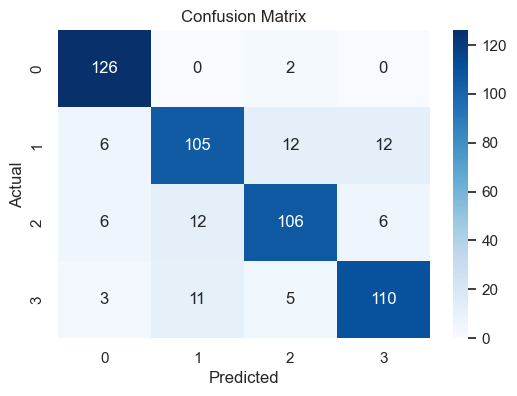

Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.98      0.94       128
           2       0.82      0.78      0.80       135
           3       0.85      0.82      0.83       130
           4       0.86      0.85      0.86       129

    accuracy                           0.86       522
   macro avg       0.86      0.86      0.86       522
weighted avg       0.85      0.86      0.85       522



In [145]:
# Calculate accuracy
accuracy_dt = accuracy_score(y_test_resampled, y_pred_dt)

# Print the accuracy
print(f"Accuracy: {accuracy_dt:.2f}")

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_resampled, y_pred_dt), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
class_report_dt = classification_report(y_test_resampled, y_pred_dt)
print("Classification Report:")
print(class_report_dt)

In [151]:
print(best_params_dt)

{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}


In [ ]:
# Task
dt_Tune = classification_task(best_model_dt, X_train_scaled, y_resampled_under, 
                                                            X_test_scaled, y_test_resampled, y_pred_dt, 'DT')
dt_Tune